In [1]:
import pandas as pd
import polars as pl
from rdkit import Chem

In [2]:
training_df = pl.read_csv('data/training_smiles.csv')
test_df = pl.read_csv('data/test_smiles.csv')

## Sanity check

In [3]:
# Is this binary? Yes
training_df['ACTIVE'].unique()

ACTIVE
f64
0.0
1.0


In [4]:
training_df

INDEX,SMILES,ACTIVE
i64,str,f64
1,"""CCOc1cc(CNc2cccc3ccccc23)cc(Br…",0.0
2,"""COc1cc(-c2ccc(Nc3ccccc3C(=O)O)…",0.0
3,"""O=c1cc(O)n(-c2ccc(Cl)cc2)c(=S)…",0.0
4,"""COc1ccc(NC(=O)C/C(C)=N/NC(=O)C…",0.0
5,"""CC(=O)/C=C(\C)NCCNc1c(F)c(F)c(…",0.0
…,…,…
208934,"""COc1cccc(C(=O)Nc2ccc(S(=O)(=O)…",0.0
208935,"""Cc1ccc(Cn2cc(C(=O)c3ccc(F)cc3)…",0.0
208936,"""COc1c(Cl)cc(Cl)cc1/C=N/NC(=O)c…",0.0


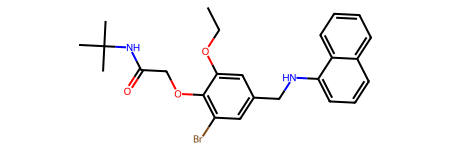

In [5]:
first_entry = training_df['SMILES'].first()

m1 = Chem.MolFromSmiles(first_entry)
m1

In [6]:
m1.GetNumAtoms()

31

In [7]:
import rdkit.Chem.rdMolDescriptors as d

d.CalcExactMolWt(m1)

484.136154888

## Feature engineering

In [8]:
def calc_mol_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return d.CalcExactMolWt(mol)

# Apply the function to the SMILES column
training_df = training_df.with_columns(
    pl.col("SMILES").map_elements(calc_mol_descriptors, return_dtype=pl.Float64).alias("MolWeight")
)

[16:42:46] WARNING: not removing hydrogen atom without neighbors


In [9]:
import rdkit.Chem.Lipinski as l

def calc_lipinski(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return l.HeavyAtomCount(mol)

# Apply the function to the SMILES column
training_df = training_df.with_columns(
    pl.col("SMILES").map_elements(calc_lipinski, return_dtype=pl.Int64).alias("Lipinski-HAcount")
)

[16:44:20] WARNING: not removing hydrogen atom without neighbors


In [10]:
training_df.select("MolWeight", "Lipinski-HAcount")

MolWeight,Lipinski-HAcount
f64,i64
484.136155,31
484.163436,36
253.991676,16
383.184506,28
320.114791,22
…,…
412.120526,29
429.137636,32
507.130091,34


## Make prediction

In [11]:
from sklearn.model_selection import train_test_split

X = training_df['MolWeight', 'Lipinski-HAcount']
y = training_df['ACTIVE']

X_train, X_test, y_train, y_val = train_test_split(X, y, test_size=.2)

In [12]:
from xgboost import XGBClassifier

# Taken from https://xgboost.readthedocs.io/en/stable/get_started.html
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

In [13]:
X_train, y_train

(shape: (167_150, 2)
 ┌────────────┬──────────────────┐
 │ MolWeight  ┆ Lipinski-HAcount │
 │ ---        ┆ ---              │
 │ f64        ┆ i64              │
 ╞════════════╪══════════════════╡
 │ 359.119129 ┆ 25               │
 │ 406.076947 ┆ 27               │
 │ 381.168856 ┆ 28               │
 │ 313.077264 ┆ 22               │
 │ 289.017557 ┆ 18               │
 │ …          ┆ …                │
 │ 373.247775 ┆ 27               │
 │ 355.153206 ┆ 26               │
 │ 264.085855 ┆ 19               │
 │ 431.987632 ┆ 26               │
 │ 398.141262 ┆ 28               │
 └────────────┴──────────────────┘,
 shape: (167_150,)
 Series: 'ACTIVE' [f64]
 [
 	0.0
 	0.0
 	0.0
 	0.0
 	0.0
 	…
 	0.0
 	0.0
 	0.0
 	0.0
 	0.0
 ])

In [14]:
bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
preds = bst.predict(X_test)
preds

array([0, 0, 0, ..., 0, 0, 0])